In [78]:
import pandas as pd
import numpy as np
weather = pd.read_csv("weather.csv")

# Renaming all parameters to more reasonable names
weather.rename(columns = {'Data.Precipitation':'Precipitation', 'Date.Month':'Month', 
                          'Date.Week of':'Week', 'Date.Year':'Year', 'Station.City':'City', 'Station.Code':'Code',
                          'Station.State':'State', 'Data.Temperature.Avg Temp':'AverageTemp',
                          'Data.Temperature.Max Temp':'MaxTemp', 'Data.Temperature.Min Temp':'MinTemp', 
                          'Data.Wind.Direction':'WindDirection', 'Data.Wind.Speed':'WindSpeed'}, inplace = True)

# Removing Obsolete parameters
weather.drop(['Date.Full', 'Station.Location'], axis = 1, inplace = True)

print("Number of samples:", len(weather))
weather.head()

Number of samples: 16743


,Precipitation,Month,Week,Year,City,Code,State,AverageTemp,MaxTemp,MinTemp,WindDirection,WindSpeed
0,0.00,1,3,2016,Birmingham,BHM,Alabama,39,46,32,33,4.33
1,0.00,1,3,2016,Huntsville,HSV,Alabama,39,47,31,32,3.86
2,0.16,1,3,2016,Mobile,MOB,Alabama,46,51,41,35,9.73
3,0.00,1,3,2016,Montgomery,MGM,Alabama,45,52,38,32,6.86
4,0.01,1,3,2016,Anchorage,ANC,Alaska,34,38,29,19,7.80


In [79]:
# Removing samples with invalid temperature data

# A station is removed if it has even a single report that gives the default value. I could change this to only
# remove that specific sample, but given the size of the dataset I believe we are safe to axe any station that gives any amount
# of improper results.

# Find all of the values with improperly initialized values, and prepare allCodes to be used for the next block
remove = set()
allCodes = set()
for i in range(len(weather)):
    if (weather["MaxTemp"][i] == weather["MinTemp"][i] and weather["AverageTemp"][i] == 60): # 60 is the default value for temperature parameters
        remove.add(weather['Code'][i])
    allCodes.add(weather["Code"][i])

# Identified nine stations with invalid weather information- PSG, PTI, SYA, GST, WRG, MWN, UNK, MQE, and SNP 
print("Stations with invalid temperature information: ", remove)
print("Total number of unique stations in dataset: ", len(allCodes))

Stations with invalid temperature information:  {'SNP', 'PSG', 'PTI', 'SYA', 'MWN', 'WRG', 'UNK', 'MQE', 'GST'}
Total number of unique stations in dataset:  318


In [80]:
# Removing samples with invalid precipitation data

# Stations are only removed if they report no precipitation in every report. While these could potentially be accurate results, 
# they can be declared as outliers and reasonably removed, and it is safe to potentially catch accurate results in the crossfire
# if it means eliminating invalid values given the size of the dataset.

# Searching for stations that listed their precipitation as 0 every week
x = allCodes.copy()
i = 0
while i < len(weather) or len(x) == 0:
    if weather['Precipitation'][i] != 0.00 and weather['Code'][i] in x:
        x.remove(weather['Code'][i])
    i += 1
    
# Identified six stations with invalid precipitation information- PSG, GST, UNK, SYA, PTI, and WRG
print("Stations with invalid precipitation information", x)
remove.update(x)

Stations with invalid precipitation information {'PTI', 'SYA', 'WRG', 'UNK', 'PSG', 'GST'}


In [81]:
# Removing samples with invalid wind data

# Removes samples that report no wind for the entire week. Once again, while it could be possible, it is incredibly
# unlikely and worthwhile to remove because of the potential to interfere with the data.

# Searching for stations that listed their wind speed and direction as 0 every week
i = 0
while i < len(weather) or len(allCodes) == 0:
    if weather['WindSpeed'][i] != 0.00 and weather['WindDirection'][i] != 0.00 and weather['Code'][i] in allCodes:
        allCodes.remove(weather['Code'][i])
    i += 1

# Identified four stations with invalid wind data- LZK, PTI, EKA, and MQT
print("Stations with invalid wind information", allCodes)
remove.update(allCodes)

Stations with invalid wind information {'PTI', 'MQT', 'EKA', 'LZK'}


In [82]:
# Remove all instances of the stations flagged in the previous blocks. Seperates the original data into originalData

originalData = weather.copy()

print(len(weather))
invalidData = pd.DataFrame()
print("REMOVING: ", remove)
for i in range(len(weather)):
    if weather["Code"][i] in remove:
        invalidData = invalidData.append(weather.loc[i])
        weather.drop(i, axis = 0, inplace = True)
        
print("Number of samples removed: ", len(invalidData))
print("New number of samples: ", len(weather))
weather.reset_index(drop = True, inplace = True)
invalidData.head()

16743
REMOVING:  {'SNP', 'LZK', 'PSG', 'PTI', 'SYA', 'MWN', 'MQT', 'EKA', 'WRG', 'UNK', 'MQE', 'GST'}
Number of samples removed:  541
New number of samples:  16202


,AverageTemp,City,Code,MaxTemp,MinTemp,Month,Precipitation,State,Week,WindDirection,WindSpeed,Year
25,60.0,Petersburg,PSG,60.0,60.0,1.0,0.00,Alaska,3.0,18.0,1.83,2016.0
26,60.0,Puntilla Lake,PTI,60.0,60.0,1.0,0.00,Alaska,3.0,0.0,0.00,2016.0
27,60.0,Shemya,SYA,60.0,60.0,1.0,0.00,Alaska,3.0,0.0,0.00,2016.0
30,32.0,St Paul Island,SNP,35.0,29.0,1.0,0.15,Alaska,3.0,22.0,9.03,2016.0
42,42.0,North Little Rock,LZK,49.0,34.0,1.0,0.00,Arkansas,3.0,0.0,0.00,2016.0


### Initial Cleaning Analysis
So far information from 12 stations have been removed. There is a notably high amount of overlap among these groups, as specific stations tended to neglect to report high amounts of information. One station failed all three reports, reporting no useful information at all; The PTI station represents Puntilla Lake, Alaska- a small lake out in the middle of nowhere. 

Of the 318 stations available, only having to cull 12 of them is pretty good: less than 4% of the dataset was loss. While performing the above tasks, I came to an interesting realization: not all stations are evenly represented. Some stations don't present data for every week. I initially considered removing these stations as well, but after consideration their presence doesn't interfere with the actual nature of our testing, so I opted to leave them in.

In [83]:
# Information about removed data
invalidData.reset_index(drop = True, inplace = True)

x = remove.copy()
i = 0
while len(x) != 0 and i < len(invalidData):
    if invalidData['Code'][i] in x:
        print(invalidData['Code'][i], ": ", invalidData['City'][i], ",", invalidData['State'][i])
        x.remove(invalidData['Code'][i])
    i += 1

PSG :  Petersburg , Alaska
PTI :  Puntilla Lake , Alaska
SYA :  Shemya , Alaska
SNP :  St Paul Island , Alaska
LZK :  North Little Rock , Arkansas
EKA :  Eureka , California
MQE :  Milton , Massachusetts
MQT :  Marquette , Michigan
MWN :  Mt. Washington , New Hampshire
GST :  Gustavus , Alaska
WRG :  Wrangell , Alaska
UNK :  Unalakleet , Alaska


### Removed Data Analysis
Not much of interest was found regarding the removed samples. Unsurprisingly, all of the stations provided information to have relatively low populations (for comparison, Springfield, MO has a population of 169,724), and likely have minimal financial backing. Most of the removed stations are from Alaska, which I suspect could prove to be troublesome for our analysis as a whole. Later on I plan to implement visual representations of the dataset, including the data that has been removed.

Population of deleted data samples:  
Petersburg (PSG):        3,000  
Puntilla Lake (PTI):     0  
Shemya (SYA):            27  
St Paul Island (SNP):    492  
North Little Rock (LZK): 64,162  
Eureka (EKA):            26,489  
Milton (MQE):            27,003  
Marquette (MQT):         20,394  
Mt. Washington (MWN):    0   
Gustavus (GST):          642  
Wrangell (WRG):          2,055  
Unalakleet (UNK):        760  


In [84]:
# State information in Weather

# Some stations write their state using the abbreviation instead of the full state name
weather.replace('DE', 'Delaware', inplace = True)
weather.replace('VA', 'Virginia', inplace = True)

stateList = weather['State'].unique().tolist()    # List of all unique states in weather
stateCount = [0 for i in range(len(stateList))]   # Counts the number of appearances of each state in the corresponding index
print(stateList)

# Count the number of appearances of each state
for i in range(len(weather)):
    stateCount[stateList.index(weather['State'][i])] += 1

# Print results
print("\n  STATE     APPEARANCES  DISTRIBUTION")
for i in range(len(stateList)):
    percentage = (stateCount[i]/len(weather)) * 100
    print(stateList[i], end = ": ")
    for ii in range(15 - len(stateList[i])):
        print(" ", end = "") 
    print(stateCount[i], "     ", round(percentage, 3), "%")

# The number of representatives per state in each of the three states that had a number of results that weren't multiples of 53
print("\n\nCalifornia stations: \n", weather[weather.State == 'California'].Code.value_counts())
print("\nTennessee stations: \n", weather[weather.State == 'Tennessee'].Code.value_counts())
print("\nLouisiana stations: \n", weather[weather.State == 'Louisiana'].Code.value_counts())

['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Virginia', 'Vermont', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']

  STATE     APPEARANCES  DISTRIBUTION
Alabama:         212       1.308 %
Alaska:          1431       8.832 %
Arizona:         265       1.636 %
Arkansas:        106       0.654 %
California:      946       5.839 %
Colorado:        318       1.963 %
Connecticut:     106       0.654 %
Delaware:        106       0.654 %
Florida:         636       3.925 %
Georgia

### State Data Analysis
Our dataset includes information from all 50 states, plus information from one station in Puerto Rico. Data initially included DE and VA, as states, but they have been corrected in the above cell to Delaware and Virginia respectively. Unsurprisingly, the number of stations per state generally coincides with it's size; smaller states like Rhodes Islands only have a single station representing them, while larger states like Texas have many. I worry that Alaska might have a heavy impact on our results as a whole and potentially skewing our data. It has the highest number of stations of any state, making up nearly 9% of the entire dataset (even after removing seven stations that had invalid data), and is known for having severe weather.  


The weather dataset covers information over the span of 53 weeks, and as such the number of reports given within each state is a multiple of 53, with a few exceptions: Tennessee, Louisiana, and California. The stations are OQT, ASD, and NID respectively. OQT and ASD both had a 4 week break in their information, starting on the week of July 3rd and ending on the week of August 7th. These stations are located nowehere near each other and no others were affected, so this is likely just a weird quirk with the dataset. NID lacks information for the last 8 weeks of the data collection period. Oddly enough, data for all of these seem to be available online, so the problem lies with the dataset's data compilation, rather than the station's ability to provide information.

In [85]:
# Remove specific instances of data that fall outside of two standard deviations (outliers)
# Unsure if this should be done or not
def cullOutliers(dataFrame):
    # Establish the standard deviation and the mean for each attribute being measured
    pstd = dataFrame['Precipitation'].std()
    pmean = dataFrame['Precipitation'].mean()
    print("Precipitation Standard Deviation:" , pstd, "\nPrecipitation Mean: ",  pmean)

    tstd = dataFrame['AverageTemp'].std()
    tmean = dataFrame['AverageTemp'].mean()
    print("\nTemperature Standard Deviation: ", tstd, "\nTemperature Mean: ", tmean)

    wstd = dataFrame['WindSpeed'].std()
    wmean = dataFrame['WindSpeed'].mean()
    print("\nWind Speed Standard Deviation", wstd, "\nWind Speed Mean", wmean)

    removedCount = 0
    
    for i in range(len(dataFrame)):
        if (abs(dataFrame['Precipitation'][i] - pmean) > (pstd * 3) or 
            abs(dataFrame['AverageTemp'][i] - tmean) > (tstd * 3) or 
            abs(dataFrame['WindSpeed'][i] - wmean) > (wstd * 3)):
            dataFrame.drop([i], inplace = True)
            removedCount += 1

    dataFrame.reset_index(drop = True, inplace = True)
    print("\n", removedCount, "outliers removed.")

In [86]:
cullOutliers(weather)
weather.reset_index(drop = True, inplace = True)

Precipitation Standard Deviation: 0.9934959839280779 
Precipitation Mean:  0.5876576965806845

Temperature Standard Deviation:  18.971604805432797 
Temperature Mean:  56.11196148623627

Wind Speed Standard Deviation 3.014337867998682 
Wind Speed Mean 6.312484261202375

 518 outliers removed.


In [87]:
# Saving the newly edited CSV file
weather.to_csv('weather_revised.csv', index = False)
weather.head()

,Precipitation,Month,Week,Year,City,Code,State,AverageTemp,MaxTemp,MinTemp,WindDirection,WindSpeed
0,0.00,1,3,2016,Birmingham,BHM,Alabama,39,46,32,33,4.33
1,0.00,1,3,2016,Huntsville,HSV,Alabama,39,47,31,32,3.86
2,0.16,1,3,2016,Mobile,MOB,Alabama,46,51,41,35,9.73
3,0.00,1,3,2016,Montgomery,MGM,Alabama,45,52,38,32,6.86
4,0.01,1,3,2016,Anchorage,ANC,Alaska,34,38,29,19,7.80


In [88]:
import matplotlib.pyplot as plt

# Generates a set of graphs for a specific weather station representing its wind speed, precipitation, and temperature over the
# course of 2016.
# Takes 
def graphByCode(intake):
    fig = plt.figure(figsize = (12, 12))
    windGraph = fig.add_subplot(3,3,1)
    precipitationGraph = fig.add_subplot(3,3,2)
    tempGraph = fig.add_subplot(3,3,3)

    windGraph.set(xlabel = 'Week', ylabel = 'Wind Speed (mph)', title = 'Wind Graph')
    precipitationGraph.set(xlabel = 'Week', ylabel = 'Precipitation (in)', title = 'Precipitation Graph')
    tempGraph.set(xlabel = 'Week', ylabel = 'Temperature (F)', title = 'Temperature Graph')

    wValues = []
    pValues = []
    tValues = []
    xvalues = []
    if intake in originalData['Code'].unique().tolist():
        if intake in invalidData['Code'].unique().tolist():
            sortedDB = invalidData[invalidData.Code == intake]
        else:
            sortedDB = weather[weather.Code == intake]
        sortedDB.reset_index(drop = True, inplace = True)
        for i in range(len(sortedDB)):
            wValues.append(sortedDB['WindSpeed'][i])
            pValues.append(sortedDB['Precipitation'][i])
            tValues.append(sortedDB['AverageTemp'][i])
            xvalues.append(i)
    else:
        print("Invalid input")

    fig.suptitle((intake + ' Station Weather Information'), fontsize = 15)
    windGraph.plot(xvalues, wValues)
    precipitationGraph.plot(xvalues, pValues)
    tempGraph.plot(xvalues, tValues)

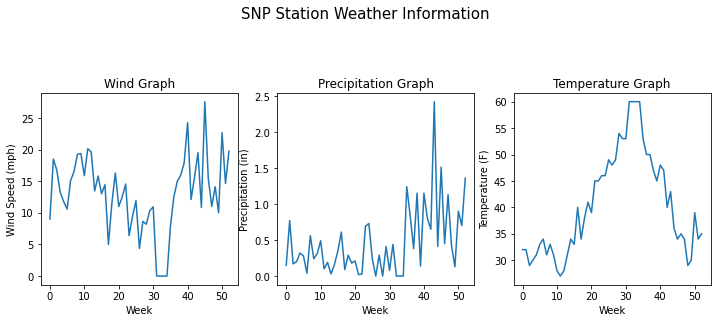

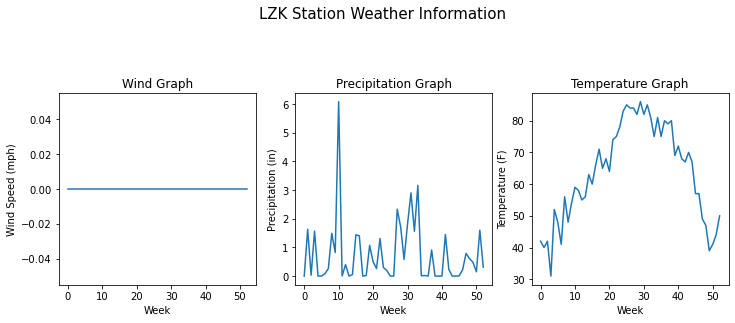

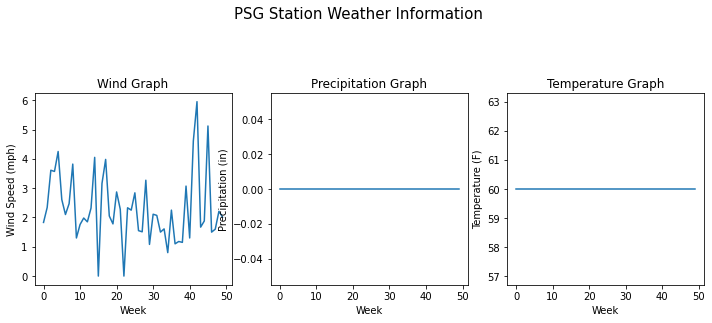

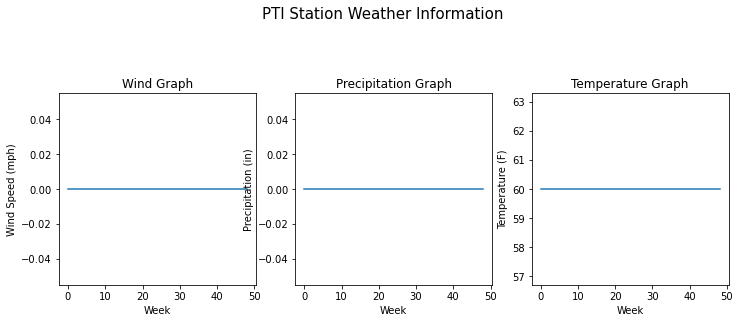

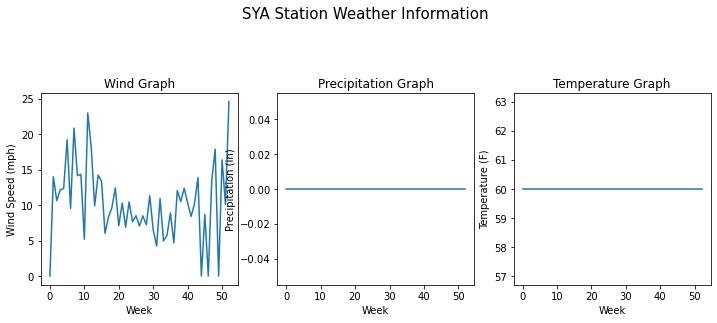

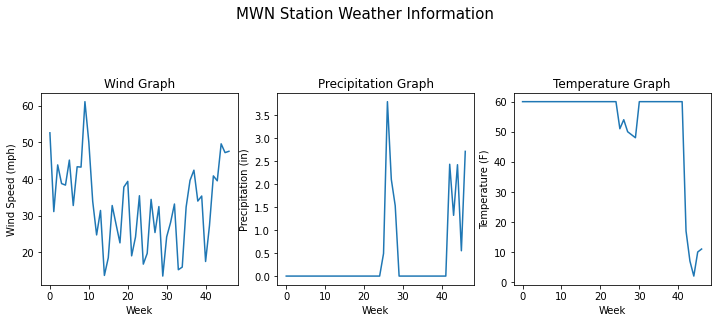

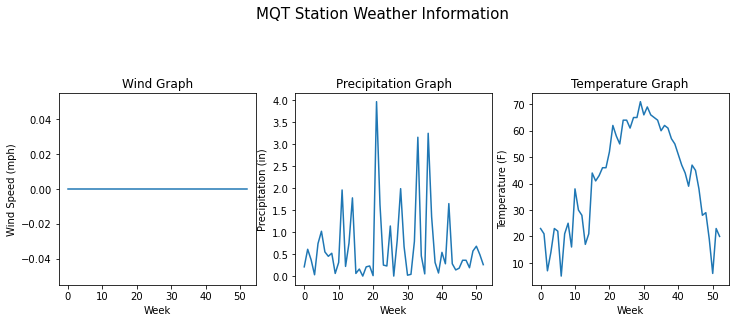

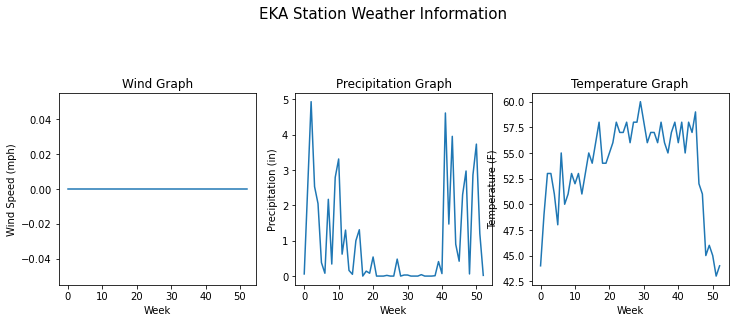

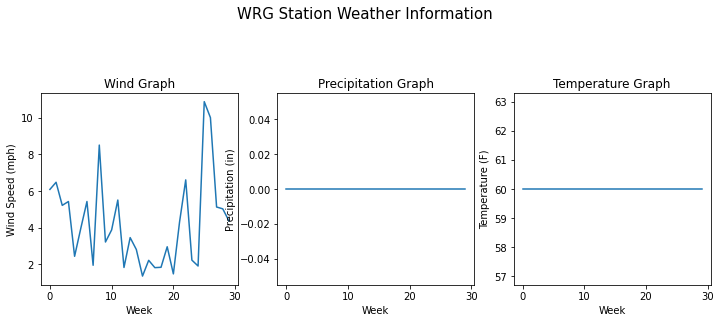

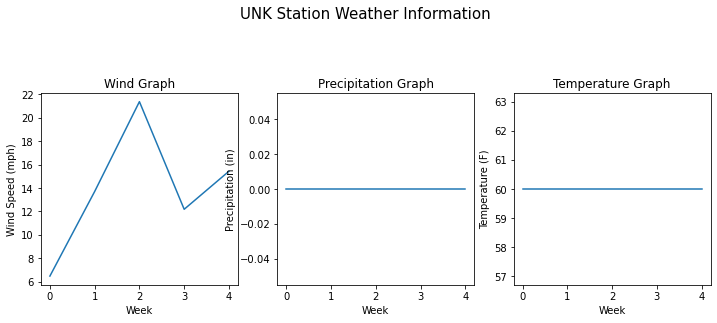

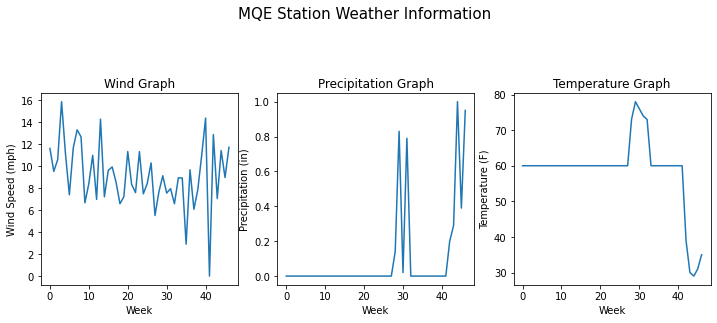

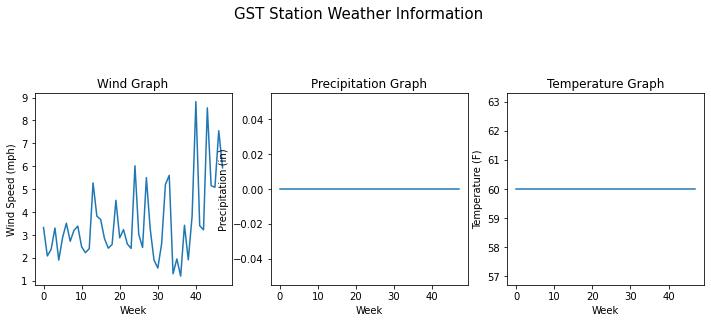

In [89]:
# Generating graphs for every value that was removed from the dataset
for i in remove:
    graphByCode(i)